### Create circuit which converts a qubit register in arbitrary state to basis state |0>
Algorithm described in http://www.informatik.uni-bremen.de/agra/doc/konf/2016_ismvl_logic_synthesis_quantum_state_generation.pdf


In [1]:
import numpy as np
from numpy.random import default_rng

from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit import QuantumCircuit

import math
import cmath
from math import e

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# setup number of qubits
num_of_qubits = 5

statevec_sim = Aer.get_backend("statevector_simulator")
qasm_sim = Aer.get_backend('qasm_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

In [2]:
def random_statevector(dims, seed=None):
    """Generator a random Statevector.

    The statevector is sampled from the uniform (Haar) measure.

    Args:
        dims (int or tuple): the dimensions of the state.
        seed (int or np.random.Generator): Optional. Set a fixed seed or
                                           generator for RNG.

    Returns:
        Statevector: the random statevector.
    """
    if seed is None:
        rng = np.random.default_rng()
    elif isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = default_rng(seed)

    dim = np.product(dims)

    # Random array over interval (0, 1]
    x = rng.random(dim)
    x += x == 0
    x = -np.log(x)
    sumx = sum(x)
    phases = rng.random(dim) * 2.0 * np.pi
    return Statevector(np.sqrt(x / sumx) * np.exp(1j * phases), dims=dims)

In [3]:
def rotation_gates(state_vector, n):
    n1 = int(n/2)
    z_rot_angle = np.zeros(n1, dtype = float)
    y_rot_angle = np.zeros(n1, dtype = float)

    for i in range(0, n, 2):
        z_rot_angle[int(i/2)] = (cmath.phase(state_vector[i]) -
        cmath.phase(state_vector[i+1]))
        
        # Create Ry matrix
        a = cmath.polar(state_vector[i])[0]
        b = cmath.polar(state_vector[i+1])[0]
        y_rot_angle[int(i/2)] = 2.0 * np.arcsin((a - b)/math.sqrt(2.0*(a*a + b*b)))
        
    return (z_rot_angle, y_rot_angle)

In [4]:
def create_CnRZ_CnRY_gates(circ, num_q, z_angle, y_angle):
#  create control RZ & RY with multiple control qubits

    circ.ccx(1, 2, num_q)
    for i in range(0, num_q-3):
        circ.ccx(i+3, num_q+i, num_q+i+1)

    circ.crz(z_angle, 2*num_q-3, 0)
    circ.cry(y_angle, 2*num_q-3, 0)
    
    for i in range(0, num_q-3):
        circ.ccx(num_q-i-1, 2*num_q-4-i, 2*num_q-3-i)
    circ.ccx(1, 2, num_q)
    
    return (circ)


In [5]:
# Generate random one qubit state
dim_of_qubits = 2**num_of_qubits
vec = random_statevector(dim_of_qubits,0)
#print(vec)

#print(len(vec.data), vec.dim)
#for i in range(vec.dim):
    #print('polar coord. ', cmath.polar(vec.data[i]))
    #print ('module ', abs(vec.data[i]), 'phases ', cmath.phase(vec.data[i]))

statevec = np.zeros((dim_of_qubits), dtype = complex)
statevec = vec.data

In [6]:
# create circuit and initialize qubit
qc = QuantumCircuit(num_of_qubits)

# Initialize circuit with those random state vector values
lst = [*range(0, num_of_qubits)]
qc.initialize(statevec, lst) # data for initializing and list of qubits to be initialized

# create and add extra qubits for implementing CCRZ
q2 = QuantumRegister(num_of_qubits-2, name='ancillary')
qc.add_register(q2)

#qc.draw(output='mpl')

In [7]:
last_qubit_num = num_of_qubits - 1
dim1 = 2**last_qubit_num
str_len = str(last_qubit_num)
curr_qubit_num = 1             # use this qubit# for SWAP gate

for k in range(num_of_qubits):
    z_ang, y_ang = rotation_gates(statevec, dim_of_qubits)

    for i in range(dim1):
        # create binary string with fixed length num_of_qubits with zero padding on left
        bin_str = format(i, '0'+str_len+'b')
        for j in range(last_qubit_num):
            if bin_str[last_qubit_num-1-j] == '0':
                qc.x(j+1)
                
        qc = create_CnRZ_CnRY_gates(qc, num_of_qubits, z_ang[i], y_ang[i])
        for j in range(last_qubit_num):
            if bin_str[last_qubit_num-1-j] == '0':
                qc.x(j+1)
        qc.barrier()
        
    
    if (curr_qubit_num <= last_qubit_num):  # Swap gates
        qc.swap(0, curr_qubit_num)
        curr_qubit_num += 1
    else:
        for j in range(num_of_qubits):
            qc.h(j)

###    res = execute(qc, backend = statevec_sim).result()
    res = statevec_sim.run(qc).result()
    statevec = res.get_statevector()
    
print('after final cycle ')
print(statevec)
for l in range(dim_of_qubits):
    print(cmath.polar(statevec[l]))


after final cycle 
Statevector([ 9.57777312e-01+2.87511078e-01j,
              3.94431303e-18+5.77216716e-17j,
             -1.36807708e-17+4.06580351e-17j,
              5.50180192e-18+4.20914496e-19j,
             -4.92480486e-18+4.94179033e-17j,
             -8.37598589e-18-4.90653893e-18j,
              2.65650496e-17+1.53148798e-17j,
             -2.80021416e-17+5.95262989e-19j,
             -1.72523488e-17+7.79801226e-17j,
              4.31127594e-18-3.46944695e-18j,
              2.08166817e-17+1.53148798e-17j,
             -2.10632477e-17-2.87418396e-18j,
             -2.77555756e-17+2.85974046e-17j,
             -1.43709198e-18-4.20914496e-19j,
             -6.93889390e-18-5.50180192e-18j,
             -1.53148798e-17-5.92271642e-18j,
             -1.62700952e-19+4.61950223e-17j,
             -8.37598589e-18-4.48562444e-18j,
              6.93889390e-18+1.04083409e-17j,
              5.50180192e-18+5.92271642e-18j,
             -2.77555756e-17-8.97124887e-18j,
             -8

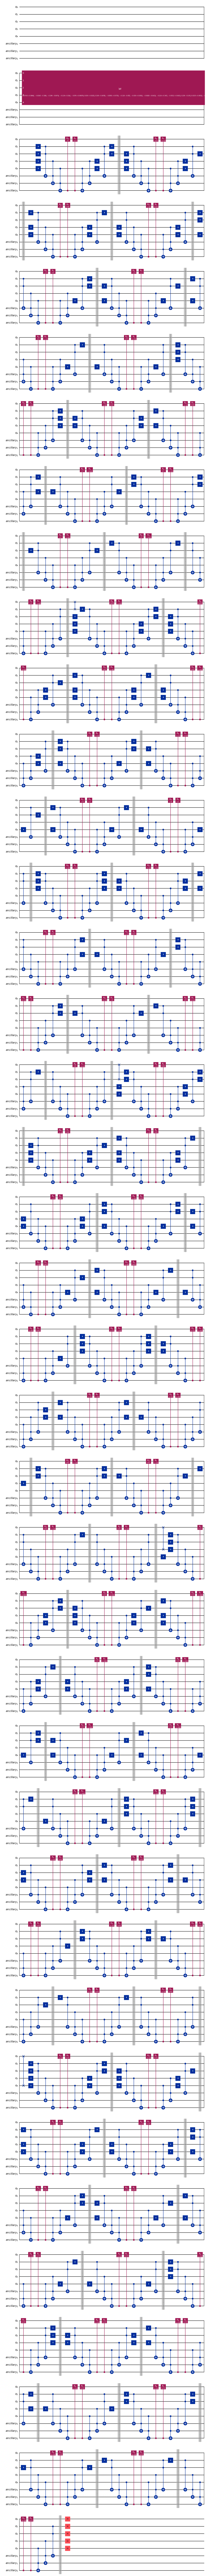

In [8]:
qc.draw(output='mpl')